In [1]:
from functions.plots import circuit_plot,matrix_plot,stats_plot
from functions.calculating import get_cmap,get_matrix,get_stats, energy_cmap
from functions.importing import retrieve_chain,retrieve_cif
import os

In [ ]:
fileformat = input('cif or pdb? (cif/pdb) \n')
if fileformat == 'cif':
    dlinput = input('Do you want to fetch CIF\'s from Database? pdblist.txt (y/n) \n')
    if dlinput:  
        efiltering = input('apply energy filtering? (y/n)\n')
        if efiltering == 'y':
            potsign = input('positive or negative filtering? (+/-)')
            if potsign == '+':
                potential_sign = 1
            else:
                potential_sign = 0
else:
    efiltering  = input('apply energy filtering? (y/n)\n')
    dlinput = 'n'

#Enter a list with protein names that need to be downloaded (pdblist.txt)
if dlinput == 'y':  
    retrieve_cif.retrieve_cif()

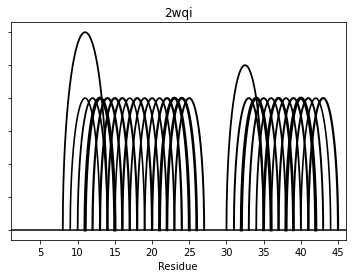

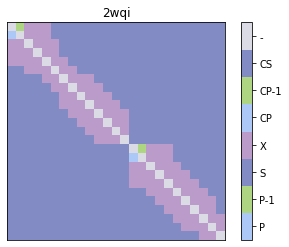

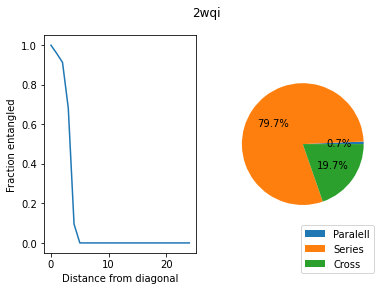

In [4]:
for files in os.listdir('input_files/' +fileformat):
    
    chain = retrieve_chain.retrieve_chain(files)
    
    #Step 1 - Draw a segment-segment based contact map (if length_filtering > 0, it is activated,          input is the max distance)
    cmap3, cmap2, protid ,numbering, res_names = get_cmap.get_cmap(chain,
    cutoff_distance=4.5,
    cutoff_numcontacts=5,
    length_filtering=0,
    exclude_neighbour=4)

    #Step 1.5 - Energy filtering
    if efiltering == 'y':
        cmap3 = energy_cmap.energy_cmap(cmap3,numbering,res_names,potential_sign)
        protid = protid + '_(' + potsign + ')ef'
   
    #Step 2 - Draw a circuit topology relations matrix
    mat, c = get_matrix.get_matrix(cmap3,protid)

    #Step 3 - Circuit topology statistics
    psc, entangled = get_stats.get_stats(mat,protid)

    #Plots
    circuit_plot.circuit_plot(cmap2,protid,numbering)
    matrix_plot.matrix_plot(mat,protid)
    stats_plot.stats_plot(entangled,psc,protid)